- 2021.11.19  u.k.  plotting of absorption profile

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [3]:
import os

import numpy as np

#%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm


In [4]:
%load_ext autoreload
%autoreload 2

from spectra_src.ImportAll import *
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [5]:
from spectra_src.Struct import Atom
from spectra_src.Util import HelpUtil

---

In [51]:
#conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/H13.conf" )
#atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=True)
conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/Ca_II.conf" )
atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=False)

In [52]:
from spectra_src.Util import MeshUtil

# common wavelength mesh in unit of Doppler width
pars = {
    "num_mesh" : 101,
    "qcore"    : 2.5,
    "qwing"    : 10.,
}

mesh = MeshUtil.make_full_line_mesh_(pars["num_mesh"], pars["qcore"], pars["qwing"])
mesh.shape

(101,)

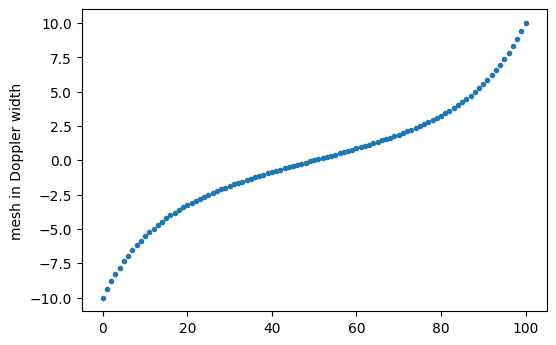

In [37]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=100)
ax.plot(mesh, "o", markersize=3)
ax.set_ylabel("mesh in Doppler width")
plt.show()

In [53]:
# parameters to calculate Doppler width
Te = 8E3  # [K]
Vt = 5E5  # [cm/s]

# line index 
kl = {
    "Ha" : 7,
    "Hb" : 8,
    "Hr" : 9,
}

In [54]:
atom.Line["w0_AA"]

array([   7325.90344755,    7293.47856377,    3969.59084683,
          3934.77643868, 1647849.22938167,    8664.52048119,
          8500.35761035,    8710.320027  ,    8544.43369491,
        448649.08998978])

In [57]:
k = 8
atom.Line["ni"][k], atom.Line["nj"][k], atom.Line["w0_AA"][k]

(3, 4, 8544.433694910716)

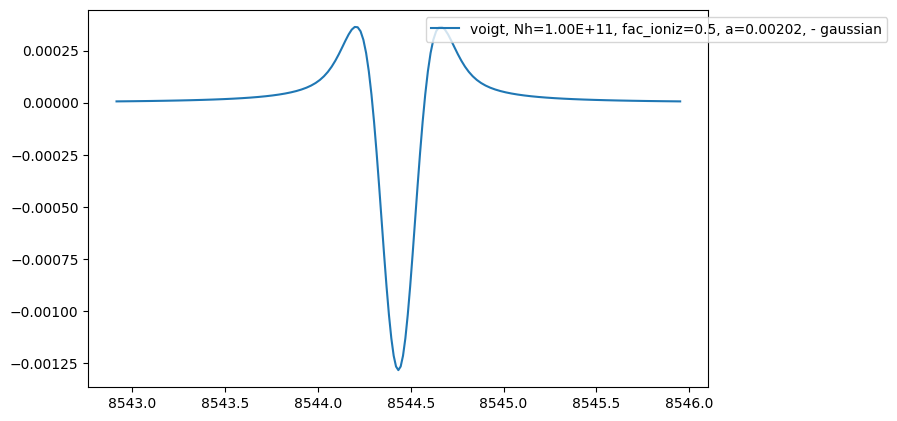

In [63]:
from spectra_src.RadiativeTransfer import Profile
from spectra_src.Atomic import BasicP
from spectra_src.Atomic import Hydrogen

#name = "Hr"
#k = kl[name]
k = 8

# Doppler width
w0 = atom.Line["w0"][k]
f0 = atom.Line["f0"][k]
#Aji = atom.Line["AJI"][k]
dop_width_cm = BasicP.doppler_width_(w0, Te, Vt, atom.Mass)
dop_width_hz = BasicP.doppler_width_(f0, Te, Vt, atom.Mass)

# wavelength mesh in [cm]
mesh_AA = (dop_width_cm * mesh[:] + w0) * 1E8

# gaussian profile
prof_g = Profile.gaussian_(mesh) # normalized

# voigt profile
prof_v = {}

for Nh in (1E11,):
    #for fac_ioniz in (0.3, 0.5, 0.8):
    for fac_ioniz in (0.5,):
        Ne          = Nh * fac_ioniz
        Nh_I_ground = Nh * (1-fac_ioniz)
        gamma = atom.Line["Gamma"][k]
        #gamma += Hydrogen.collisional_broadening_Res_and_Van_(atom.Line["ni"][k], atom.Line["nj"][k], Nh_I_ground, Te)
        #gamma += Hydrogen.collisional_broadening_LinearStark_(atom.Line["ni"][k], atom.Line["nj"][k], Ne)
        a = gamma / ( 4. * CST.pi_ * dop_width_hz )
        prof_v[f"Nh={Nh:1.2E}, fac_ioniz={fac_ioniz:.1f}, a={a:.5f}"] = Profile.voigt_(a, mesh)

# plots
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
#ax.plot(mesh_AA, prof_g, "k-", label="gaussian")
for key, prof in prof_v.items():
    ax.plot(mesh_AA, prof[:] - prof_g[:], "-", label=f"voigt, {key}, - gaussian")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()